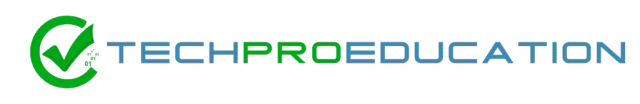

# Raisin Class Prediction

Data Set Information:

Images of Kecimen and Besni raisin varieties grown in Turkey were obtained with CVS. A total of 900 raisin grains were used, including 450 pieces from both varieties. These images were subjected to various stages of pre-processing and 7 morphological features were extracted. These features have been classified using three different artificial intelligence techniques.


Attribute Information:

1. Area: Gives the number of pixels within the boundaries of the raisin.
2. Perimeter: It measures the environment by calculating the distance between the boundaries of the raisin and the pixels around it.
3. MajorAxisLength: Gives the length of the main axis, which is the longest line that can be drawn on the raisin.
4. MinorAxisLength: Gives the length of the small axis, which is the shortest line that can be drawn on the raisin.
5. Eccentricity: It gives a measure of the eccentricity of the ellipse, which has the same moments as raisins.
6. ConvexArea: Gives the number of pixels of the smallest convex shell of the region formed by the raisin.
7. Extent: Gives the ratio of the region formed by the raisin to the total pixels in the bounding box.
8. Class: Kecimen and Besni raisin.

https://archive.ics.uci.edu/ml/datasets/Raisin+Dataset

# Import libraries

In [6]:
pip install cufflinks

Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import cufflinks as cf

from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_auc_score, auc
from sklearn.metrics import roc_curve, average_precision_score, precision_recall_curve
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

## Exploratory Data Analysis and Visualization

In [8]:
df = pd.read_excel("Raisin_Dataset.xlsx") 

In [9]:
df.head()

Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0  87524       442.246011       253.291155      0.819738       90546   
1  75166       406.690687       243.032436      0.801805       78789   
2  90856       442.267048       266.328318      0.798354       93717   
3  45928       286.540559       208.760042      0.684989       47336   
4  79408       352.190770       290.827533      0.564011       81463   

     Extent  Perimeter    Class  
0  0.758651   1184.040  Kecimen  
1  0.684130   1121.786  Kecimen  
2  0.637613   1208.575  Kecimen  
3  0.699599    844.162  Kecimen  
4  0.792772   1073.251  Kecimen

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [11]:
df.shape

(900, 8)

In [12]:
df.duplicated().sum() 

0

In [13]:
df.isnull().sum().any() 

False

In [14]:
df.describe().T

count          mean           std           min  \
Area             900.0  87804.127778  39002.111390  25387.000000   
MajorAxisLength  900.0    430.929950    116.035121    225.629541   
MinorAxisLength  900.0    254.488133     49.988902    143.710872   
Eccentricity     900.0      0.781542      0.090318      0.348730   
ConvexArea       900.0  91186.090000  40769.290132  26139.000000   
Extent           900.0      0.699508      0.053468      0.379856   
Perimeter        900.0   1165.906636    273.764315    619.074000   

                          25%           50%            75%            max  
Area             59348.000000  78902.000000  105028.250000  235047.000000  
MajorAxisLength    345.442898    407.803951     494.187014     997.291941  
MinorAxisLength    219.111126    247.848409     279.888575     492.275279  
Eccentricity         0.741766      0.798846       0.842571       0.962124  
ConvexArea       61513.250000  81651.000000  108375.750000  278217.000000  
Extent               0.670869      0.707367       0.734991       0.835455  
Perimeter          966.410750   1119.509000    1308.389750    2697.753000

In [15]:
df["Class"].value_counts()

Kecimen    450
Besni      450
Name: Class, dtype: int64

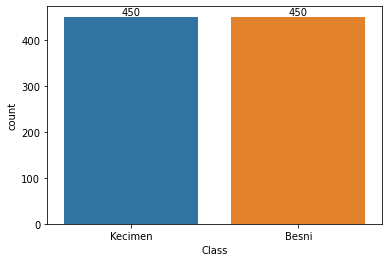

In [16]:
ax= sns.countplot(df["Class"])
ax.bar_label(ax.containers[0]); ## balance bir data ve accuracy hata metrigini kullanabiliriz

We have prety same amout of classes in the data set. So I can use accuracy as a metric to evaluate the performance of the classifier.

In [17]:
df["Class"] = df["Class"].map({"Kecimen":0,"Besni":1}) ## kecimen ve besni class sinifini Binary moduna cevirdik, 
                                                        ## bunu replace ile de yapabilirdik

In [18]:
df

Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0    87524       442.246011       253.291155      0.819738       90546   
1    75166       406.690687       243.032436      0.801805       78789   
2    90856       442.267048       266.328318      0.798354       93717   
3    45928       286.540559       208.760042      0.684989       47336   
4    79408       352.190770       290.827533      0.564011       81463   
..     ...              ...              ...           ...         ...   
895  83248       430.077308       247.838695      0.817263       85839   
896  87350       440.735698       259.293149      0.808629       90899   
897  99657       431.706981       298.837323      0.721684      106264   
898  93523       476.344094       254.176054      0.845739       97653   
899  85609       512.081774       215.271976      0.907345       89197   

       Extent  Perimeter  Class  
0    0.758651   1184.040      0  
1    0.684130   1121.786      0  
2    0.637613   1208.575      0  
3    0.699599    844.162      0  
4    0.792772   1073.251      0  
..        ...        ...    ...  
895  0.668793   1129.072      1  
896  0.636476   1214.252      1  
897  0.741099   1292.828      1  
898  0.658798   1258.548      1  
899  0.632020   1272.862      1  

[900 rows x 8 columns]

In [70]:
df.iloc[:,:-1].iplot(kind="box")  ## iplot interaktif sekilde grafikler olusturmak icin kullaniliyor. 
                                    ## iloc da -1 yazmamizin sebebi class sinifini incelemek istemiyoruz 

In [20]:
fig = px.box(df, color="Class", color_discrete_map={"Kecimen":'#FF0000',"Besni":'#00FF00'})
fig.show() # class bazinda outlier lari incelemek icin kullandigimiz kod

In [21]:
df.iplot(kind="bar")    

In [22]:
fig = px.bar(df,x=df.index,y="Area",color="Class",color_discrete_map={"Kecimen":'#FF0000',"Besni":'#00FF00'}) ## ff renk kodlari
fig.show();

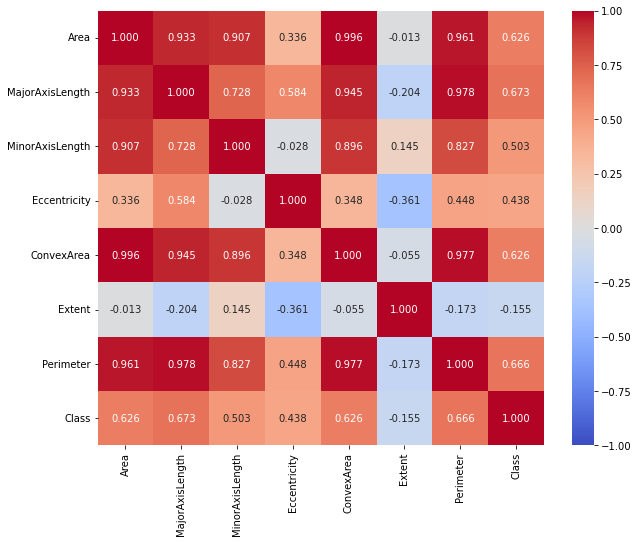

In [23]:
plt.figure(figsize=(10,8)) ## multicollineary logistic regresyon da cok önemli degil, fmt virgulden sonra kac hane gelecegini söyler
sns.heatmap(df.select_dtypes(include='number').corr(),vmin=-1,vmax=1, annot=True, fmt='.3f', cmap='coolwarm');

In [24]:
corr_matrix = df.corr()
fig = px.imshow(corr_matrix)
fig.show();

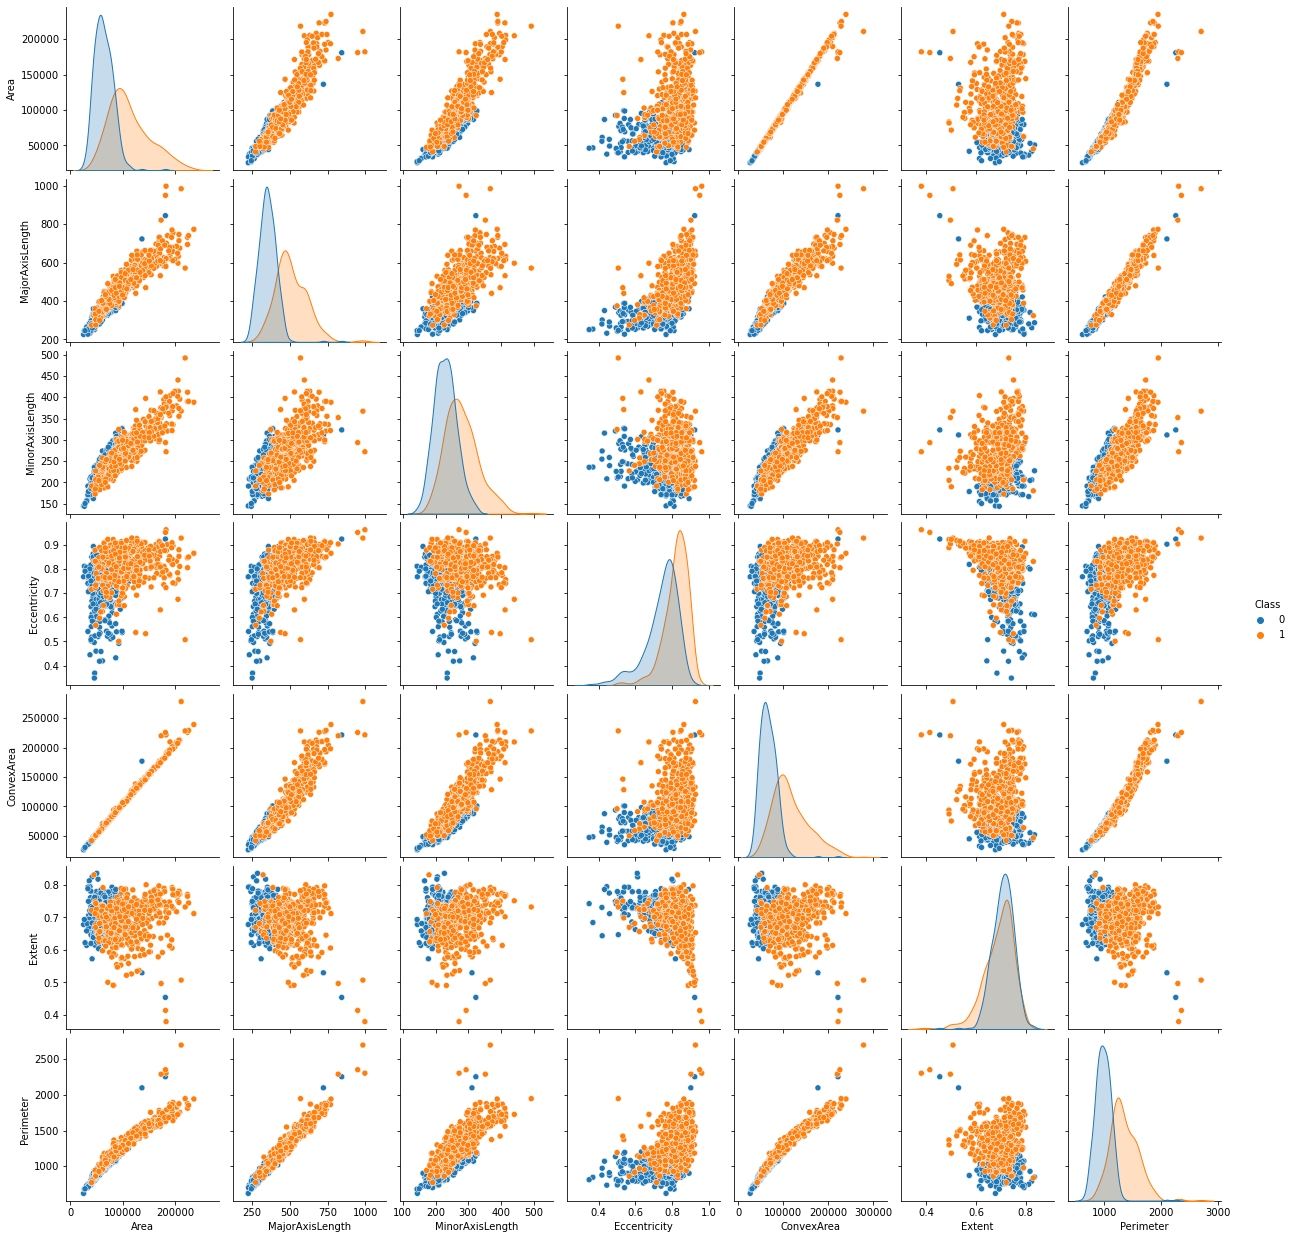

In [25]:
sns.pairplot(df, hue = "Class");

In [26]:
fig = px.scatter_3d(df, x='Perimeter', y='Area', z='Extent', color='Class')
fig.show()

## Train | Test Split and Scaling

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 56.4 KB


In [28]:
X=df.drop(["Class"], axis=1) ## stratify:unbalanced datalarda test datasina esit miktarda y koyuyor.
y=df["Class"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=10)

# Logistic Regression without Pipeline

## Scaling

In [30]:
scaler = StandardScaler() ## pipeline islemleri sirasina göre yapiyor(scale, get dummy, modeli fit etmek gibi)

In [31]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
log_model = LogisticRegression()

In [33]:
log_model.fit(X_train, y_train)

LogisticRegression()

In [34]:
log_model.coef_

array([[-0.0006259 , -0.02342022, -0.0677851 , -0.00035299,  0.00078995,
        -0.0003472 ,  0.00996104]])

# Logistic Regression with Pipeline

In [35]:
scaler =StandardScaler()## pipeline islemleri sirasina göre yapiyor(scale, get dummy, modeli fit etmek gibi)

In [36]:
log_model = LogisticRegression()

In [37]:
log_pipe = Pipeline([("scaler",scaler),("log_model",log_model)]) ## önce hangi islem yapilmasini istiyorsak onu yaziyoruz
                                                                    # scale fit transform islemlerini yapiyor 

In [38]:
log_pipe.fit(X_train, y_train)

# operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]
# pipe_model = Pipeline(steps=operations)
# pipe_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_model', LogisticRegression())])

In [39]:
y_pred=log_pipe.predict(X_test)
y_pred

array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0], dtype=int64)

In [40]:
y_pred_proba = log_pipe.predict_proba(X_test)
y_pred_proba

array([[9.09233226e-01, 9.07667744e-02],
       [2.13923600e-01, 7.86076400e-01],
       [8.61366061e-01, 1.38633939e-01],
       [9.75006614e-01, 2.49933859e-02],
       [7.18428741e-01, 2.81571259e-01],
       [9.78090204e-01, 2.19097960e-02],
       [9.67153729e-01, 3.28462709e-02],
       [2.69784269e-01, 7.30215731e-01],
       [6.22413524e-01, 3.77586476e-01],
       [8.28165778e-01, 1.71834222e-01],
       [5.50087417e-01, 4.49912583e-01],
       [6.48124125e-01, 3.51875875e-01],
       [1.33636635e-03, 9.98663634e-01],
       [7.34673174e-03, 9.92653268e-01],
       [2.22192344e-04, 9.99777808e-01],
       [4.06025195e-03, 9.95939748e-01],
       [1.03563509e-04, 9.99896436e-01],
       [2.05679569e-01, 7.94320431e-01],
       [8.80378670e-01, 1.19621330e-01],
       [7.27309014e-01, 2.72690986e-01],
       [9.54065988e-01, 4.59340125e-02],
       [6.00635256e-04, 9.99399365e-01],
       [7.48381106e-01, 2.51618894e-01],
       [9.86770325e-01, 1.32296753e-02],
       [2.814178

## X_test + y_yest + y_pred + y_pred_proba

In [41]:
test_data = pd.concat([X_test, y_test], axis=1)
test_data

Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
375   65999       326.298721       264.414877      0.585952       67971   
793   76708       458.044640       216.340932      0.881430       78694   
360   48809       332.264893       190.351365      0.819632       51847   
77    42637       293.429580       189.432158      0.763693       44052   
686   61539       364.255945       220.362020      0.796252       65462   
..      ...              ...              ...           ...         ...   
73    68520       373.235638       237.041523      0.772431       70759   
62    78571       443.822291       228.757615      0.856934       81718   
292   72219       376.650492       249.529454      0.749065       74373   
508  133101       641.509739       265.313970      0.910469      136793   
112   51448       328.289568       202.160370      0.787903       52772   

       Extent  Perimeter  Class  
375  0.676864    998.793      0  
793  0.658393   1135.680      1  
360  0.661342    928.016      0  
77   0.725119    814.182      0  
686  0.723392   1056.491      1  
..        ...        ...    ...  
73   0.712859   1049.093      0  
62   0.642193   1157.330      0  
292  0.777795   1050.221      0  
508  0.582496   1544.712      1  
112  0.704806    877.799      0  

[180 rows x 8 columns]

In [42]:
test_data["pred_proba"] = y_pred_proba[:,1]
test_data

Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
375   65999       326.298721       264.414877      0.585952       67971   
793   76708       458.044640       216.340932      0.881430       78694   
360   48809       332.264893       190.351365      0.819632       51847   
77    42637       293.429580       189.432158      0.763693       44052   
686   61539       364.255945       220.362020      0.796252       65462   
..      ...              ...              ...           ...         ...   
73    68520       373.235638       237.041523      0.772431       70759   
62    78571       443.822291       228.757615      0.856934       81718   
292   72219       376.650492       249.529454      0.749065       74373   
508  133101       641.509739       265.313970      0.910469      136793   
112   51448       328.289568       202.160370      0.787903       52772   

       Extent  Perimeter  Class  pred_proba  
375  0.676864    998.793      0    0.090767  
793  0.658393   1135.680      1    0.786076  
360  0.661342    928.016      0    0.138634  
77   0.725119    814.182      0    0.024993  
686  0.723392   1056.491      1    0.281571  
..        ...        ...    ...         ...  
73   0.712859   1049.093      0    0.241597  
62   0.642193   1157.330      0    0.777250  
292  0.777795   1050.221      0    0.169532  
508  0.582496   1544.712      1    0.999524  
112  0.704806    877.799      0    0.057765  

[180 rows x 9 columns]

In [43]:
test_data["pred"] = y_pred
test_data

Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
375   65999       326.298721       264.414877      0.585952       67971   
793   76708       458.044640       216.340932      0.881430       78694   
360   48809       332.264893       190.351365      0.819632       51847   
77    42637       293.429580       189.432158      0.763693       44052   
686   61539       364.255945       220.362020      0.796252       65462   
..      ...              ...              ...           ...         ...   
73    68520       373.235638       237.041523      0.772431       70759   
62    78571       443.822291       228.757615      0.856934       81718   
292   72219       376.650492       249.529454      0.749065       74373   
508  133101       641.509739       265.313970      0.910469      136793   
112   51448       328.289568       202.160370      0.787903       52772   

       Extent  Perimeter  Class  pred_proba  pred  
375  0.676864    998.793      0    0.090767     0  
793  0.658393   1135.680      1    0.786076     1  
360  0.661342    928.016      0    0.138634     0  
77   0.725119    814.182      0    0.024993     0  
686  0.723392   1056.491      1    0.281571     0  
..        ...        ...    ...         ...   ...  
73   0.712859   1049.093      0    0.241597     0  
62   0.642193   1157.330      0    0.777250     1  
292  0.777795   1050.221      0    0.169532     0  
508  0.582496   1544.712      1    0.999524     1  
112  0.704806    877.799      0    0.057765     0  

[180 rows x 10 columns]

In [44]:
test_data.sample(10)

Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
677  144973       614.814926       304.331531      0.868895      150534   
13    76792       338.857545       291.359202      0.510584       78842   
145   69317       393.398997       228.722883      0.813617       72170   
352   46601       277.353280       216.272051      0.626065       48457   
112   51448       328.289568       202.160370      0.787903       52772   
557   77402       469.459347       215.079951      0.888878       80680   
766   86202       437.771261       253.909321      0.814613       90825   
200   63452       334.845988       243.236481      0.687258       64925   
604  102013       453.893458       292.130181      0.765354      106036   
432   60199       375.279688       205.414052      0.836896       61711   

       Extent  Perimeter  Class  pred_proba  pred  
677  0.733669   1539.429      1    0.997637     1  
13   0.772322   1042.770      0    0.080111     0  
145  0.661674   1066.388      0    0.405920     0  
352  0.761653    820.106      0    0.014705     0  
112  0.704806    877.799      0    0.057765     0  
557  0.621329   1162.004      1    0.871010     1  
766  0.705146   1199.809      1    0.727360     1  
200  0.735317    945.523      0    0.059388     0  
604  0.637828   1266.255      1    0.827153     1  
432  0.736289    971.185      0    0.178691     0

## Model Performance

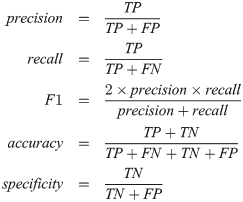

accuracy unbalanced datalarda tehlikeli olabilir,bu durumda precision ya da recall(pozitifleri yakalama orani) a bakmak gerek.
specifity toplam kac negatif var kac tanesini dogru bilmisiz onu gösteriyor. 

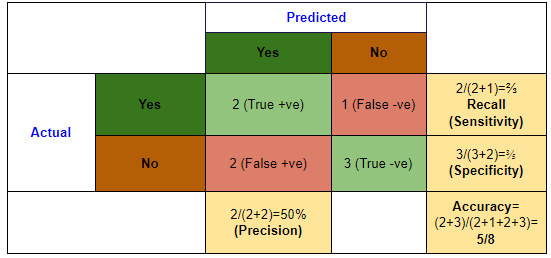

Hata metrikleri gibi burdada bu degerler var.

In [45]:
accuracy_score(y_test,y_pred)

0.8722222222222222

In [46]:
log_pipe.score(X_test, y_test)

0.8722222222222222

In [47]:
precision_score(y_test, y_pred, pos_label=1) # pos_label=1 diyerek 1. sinifin degerini bulduk.default degeri 1 dir istersek sifira da bakabiliriz

0.8941176470588236

In [48]:
recall_score(y_test, y_pred,  pos_label=1)

0.8444444444444444

In [49]:
f1_score(y_test,y_pred)

0.8685714285714287

In [50]:
confusion_matrix(y_test,y_pred)

array([[81,  9],
       [14, 76]], dtype=int64)

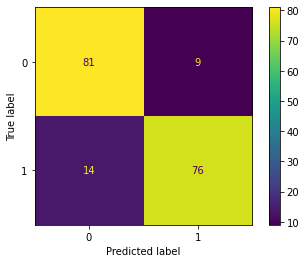

In [51]:
plot_confusion_matrix(log_pipe, X_test, y_test);

In [52]:
def eval_metric(model, X_train, y_train, X_test, y_test): ## hyper parametreler ile oynayarak hata sayisini azaltmak istiyoruz

    """ to get the metrics for the model """

    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [53]:
eval_metric(log_pipe, X_train, y_train, X_test, y_test) 

Test_Set
[[81  9]
 [14 76]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        90
           1       0.89      0.84      0.87        90

    accuracy                           0.87       180
   macro avg       0.87      0.87      0.87       180
weighted avg       0.87      0.87      0.87       180


Train_Set
[[317  43]
 [ 53 307]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       360
           1       0.88      0.85      0.86       360

    accuracy                           0.87       720
   macro avg       0.87      0.87      0.87       720
weighted avg       0.87      0.87      0.87       720



### Cross Validate

In [54]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [55]:
model = Pipeline([("scaler",scaler),("log_model",log_model)])##önce scale islemini yapsin sonra da modeli kursun istiyoruz

scores = cross_validate(model, X_train, y_train, scoring = ['precision','recall','f1','accuracy'], cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores

fit_time  score_time  test_precision  train_precision  test_recall  \
1   0.031974    0.008002        0.935484         0.881789     0.805556   
2   0.024000    0.008000        0.857143         0.878981     0.833333   
3   0.023999    0.007999        0.842105         0.887097     0.888889   
4   0.024000    0.000000        0.767442         0.879365     0.916667   
5   0.023997    0.007997        0.933333         0.876972     0.777778   
6   0.015995    0.008000        0.903226         0.869159     0.777778   
7   0.015997    0.000000        0.942857         0.875399     0.916667   
8   0.023999    0.008000        0.804878         0.882166     0.916667   
9   0.023995    0.008000        0.857143         0.871069     0.833333   
10  0.023998    0.008000        0.967742         0.875796     0.833333   

    train_recall   test_f1  train_f1  test_accuracy  train_accuracy  
1       0.851852  0.865672  0.866562       0.875000        0.868827  
2       0.851852  0.845070  0.865204       0.847222        0.867284  
3       0.848765  0.864865  0.867508       0.861111        0.870370  
4       0.854938  0.835443  0.866980       0.819444        0.868827  
5       0.858025  0.848485  0.867395       0.861111        0.868827  
6       0.861111  0.835821  0.865116       0.847222        0.865741  
7       0.845679  0.929577  0.860283       0.930556        0.862654  
8       0.854938  0.857143  0.868339       0.847222        0.870370  
9       0.854938  0.845070  0.862928       0.847222        0.864198  
10      0.848765  0.895522  0.862069       0.902778        0.864198

In [56]:
df_scores.mean()[2:]  

test_precision     0.881135
train_precision    0.877779
test_recall        0.850000
train_recall       0.853086
test_f1            0.862267
train_f1           0.865238
test_accuracy      0.863889
train_accuracy     0.867130
dtype: float64

In [57]:
eval_metric(log_pipe, X_train, y_train, X_test, y_test)

Test_Set
[[81  9]
 [14 76]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88        90
           1       0.89      0.84      0.87        90

    accuracy                           0.87       180
   macro avg       0.87      0.87      0.87       180
weighted avg       0.87      0.87      0.87       180


Train_Set
[[317  43]
 [ 53 307]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       360
           1       0.88      0.85      0.86       360

    accuracy                           0.87       720
   macro avg       0.87      0.87      0.87       720
weighted avg       0.87      0.87      0.87       720



### GridSearchCV

In [58]:
log_pipe.get_params() # modeli daha iyi hale getirmek icin gritSearch yapiyoruz, c ile hata orani ters orantili, alpha dan farkli olarak. 

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('log_model', LogisticRegression())],
 'verbose': False,
 'scaler': StandardScaler(),
 'log_model': LogisticRegression(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'log_model__C': 1.0,
 'log_model__class_weight': None,
 'log_model__dual': False,
 'log_model__fit_intercept': True,
 'log_model__intercept_scaling': 1,
 'log_model__l1_ratio': None,
 'log_model__max_iter': 100,
 'log_model__multi_class': 'auto',
 'log_model__n_jobs': None,
 'log_model__penalty': 'l2',
 'log_model__random_state': None,
 'log_model__solver': 'lbfgs',
 'log_model__tol': 0.0001,
 'log_model__verbose': 0,
 'log_model__warm_start': False}

Logistic Regression Hyperparametreleri : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [59]:
from sklearn.model_selection import GridSearchCV

model = Pipeline([("scaler",scaler),("log_model",log_model)]) 

penalty = ["l1", "l2"] 

C = np.logspace(-1, 5, 20) 

class_weight= ["balanced", None] ## unbalanced data setlerinde balanced hale getirmek icin kullanilan parametre

solver = ["lbfgs", "liblinear", "sag", "saga"] 

param_grid = {"log_model__penalty" : penalty,
              "log_model__C" : [C,1],
              "log_model__class_weight":class_weight,
              "log_model__solver":solver} 

grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=10,
                          scoring = 'accuracy',       
                          n_jobs = -1) 

In [60]:
grid_model.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log_model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'log_model__C': [array([1.00000000e-01, 2.06913808e-01, 4.28133240e-01, 8.85866790e-01,
       1.83298071e+00, 3.79269019e+00, 7.84759970e+00, 1.62377674e+01,
       3.35981829e+01, 6.95192796e+01, 1.43844989e+02, 2.97635144e+02,
       6.15848211e+02, 1.27427499e+03, 2.63665090e+03, 5.45559478e+03,
       1.12883789e+04, 2.33572147e+04, 4.83293024e+04, 1.00000000e+05]),
                                          1],
                         'log_model__class_weight': ['balanced', None],
                         'log_model__penalty': ['l1', 'l2'],
                         'log_model__solver': ['lbfgs', 'liblinear', 'sag',
                                               'saga']},
             scoring='accuracy')

In [61]:
grid_model.best_params_

{'log_model__C': 1,
 'log_model__class_weight': 'balanced',
 'log_model__penalty': 'l1',
 'log_model__solver': 'liblinear'}

In [62]:
grid_model.best_index_  ## hangi indeksteki skor en iyi bunu buluyoruz

17

In [63]:
grid_model.best_score_ ## grid model icerisine hangi skoru yazarsak o skoru aliri, biz accuracy yazdik bu nedenle accuracy skor

0.8652777777777778

In [64]:
eval_metric(grid_model, X_train, y_train, X_test, y_test) ## grid search yaparak 2 tane daha dogru tahmin yapmis 

Test_Set
[[79 11]
 [10 80]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        90
           1       0.88      0.89      0.88        90

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180


Train_Set
[[316  44]
 [ 53 307]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       360
           1       0.87      0.85      0.86       360

    accuracy                           0.87       720
   macro avg       0.87      0.87      0.87       720
weighted avg       0.87      0.87      0.87       720



## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

## ROC AUC Curve 

siniflandirma problemlerini degerlendirdigimiz metrikler, bizim featurlarimiz hangi ölcüde ayrisiyor ise roc ve auc degerleri o kadar artiyor. Balanced datalarda bakmak mantikli. 

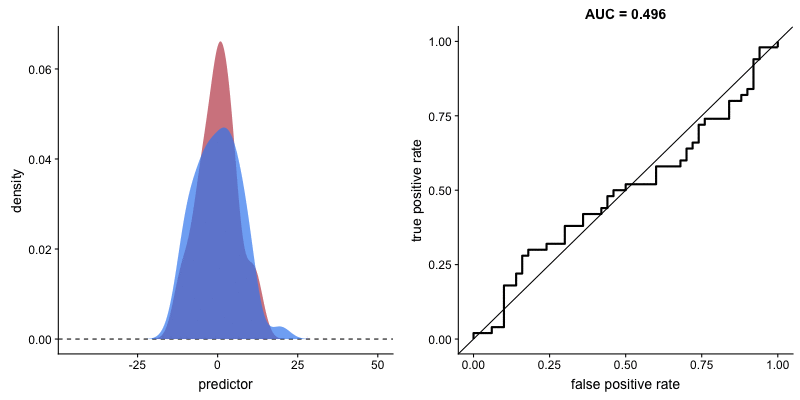

## For Imbalanced Data ROC AUC and Precision Recall Curve

Unbalanced datalarda Precision Recall Curve e bakiyoruz. 

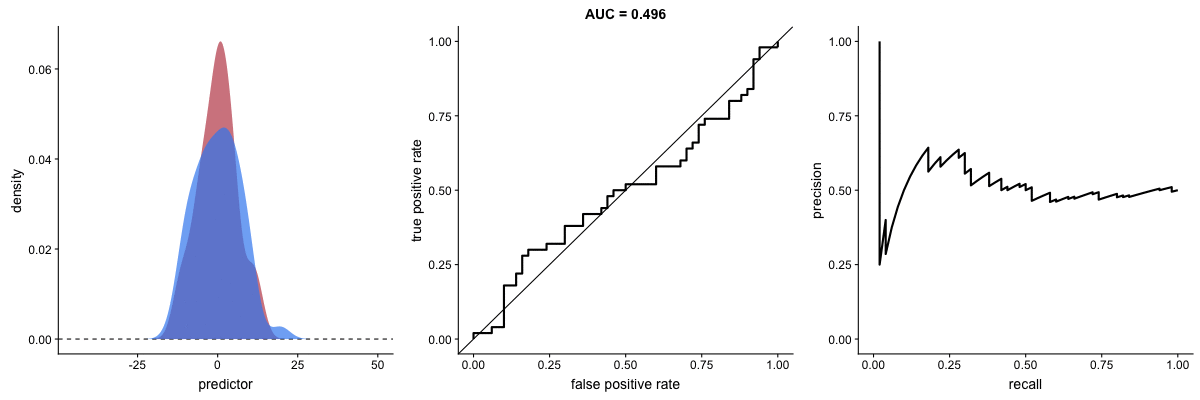

## For Imbalanced Data ROC AUC and Precision-Recall Curve

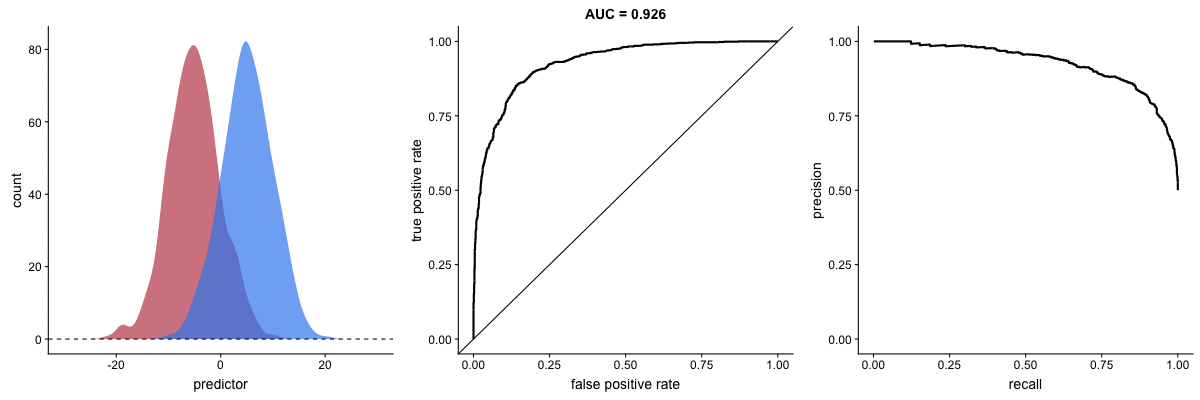

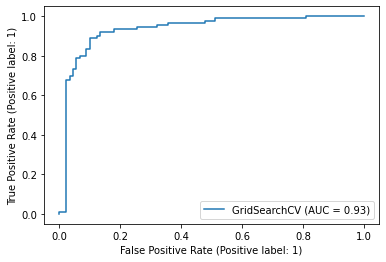

In [65]:
plot_roc_curve(grid_model, X_test, y_test); ## Auc skorunu aliyoruz 

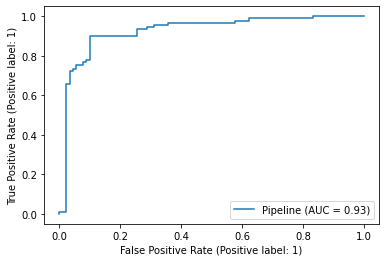

In [66]:
plot_roc_curve(log_pipe, X_test, y_test); ## gridsearch oncesindeki Auc degeri 

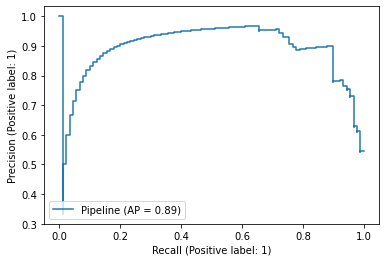

In [67]:
plot_precision_recall_curve(log_pipe, X_test, y_test);

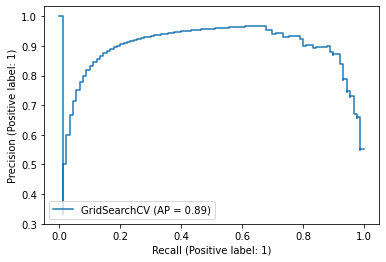

In [68]:
plot_precision_recall_curve(grid_model, X_test, y_test);

In [69]:
average_precision_score(y_test, y_pred_proba[:,1])

0.8870128026631419

# Conclusion 